## BACKGROUND

To create a model that uses data from the first 24 hours of intensive care to predict patient survival.

MIT's GOSSIS community initiative, with privacy certification from the Harvard Privacy Lab, has provided a dataset of more than 130,000 hospital Intensive Care Unit (ICU) visits from patients, spanning a one-year timeframe. This data is part of a growing global effort and consortium spanning Argentina, Australia, New Zealand, Sri Lanka, Brazil, and more than 200 hospitals in the United States.

[WiDS2020](https://www.widsconference.org/datathon.html)

**29/02/2020: Answers to some of the data questions:**
* [Negative pre_icu_los_days](https://www.kaggle.com/c/widsdatathon2020/discussion/127764#729694) - from the data stewards: the values for preiculos_days are calculated using administrative data, so sometimes there are negative numbers (that's another way you can appreciate that this data is real!). "It doesn't mean anything special other than it is probably incorrect."
* [Value of -1 in `apache_4a_hospital_death_prob` AND `apache_4a_icu_death_prob`](https://www.kaggle.com/c/widsdatathon2020/discussion/127698) - -1 means the score couldn't be calculated for some reason.  In this particular dataset, it's more likely that these patient encounters have a variable missing from the APACHE-IVa equation

## Contents
1. Load the dataset
2. Data Explanation
3. Basic EDA
4. Create dataframe for further EDA
5. Data Cleaning and more EDA
6. Correlated Features
7. Checkpoint
8. Save the dataframe

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

#plt.style.use('fivethirtyeight')

#%run ./two-histograms.ipynb

## 1. Load the dataset

In [2]:
train = pd.read_csv('../data/training_v2.csv')
print(train.shape)

(91713, 186)


In [3]:
pd.set_option('display.max_columns', 200)
train.head(10)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

## 2. Data Explanation
-----
Based on understandings gathered from the data dictionary and online research, here is a summary.

Explanation:
* `h1`: measurement taken during the first hour of patient's stay in ICU
* `d1`: measurement taken during the first 24 hours of patient's stay in ICU

There are 15 binary columns,  8 categorical columns. Majority are numerical.

### The columns can be grouped in the following way:
|Categories | Number of columns| What/When to measure |
|-----|-----|-----|
| Identifier | 4|encounter_id,hospital_id, patient_id, icu_id|
| Demographic | 15||
| APACHE | 40 |18 covariates, 4 indicators, 8 indicators for chronic ilnness, and 6 others|
| h1_vitals| 26 |diastolic/systolic blood pressure (12, invasive, noninvasive, worst)|
|||                 mbp-mean blood pressure(6, invasive/noninvasive, worst)|
|||                heartrate, resprate rate, spo2(peripheral oxygen saturation), core temperature      |
| d1_vitals| 26 |(same as h1_vitals)|
|h1_labs | 30 |albumin, bilirubin, bun(blood urea nitrogen), calcium, creatinine, glucose, hco3(bicarbonate), hemaglobin, hematocrit(volume proportion of red blood cells), inr(international normalized ratio), lactate, platelets, potassium, sodium, wbs(white blood cell counts)|
|d1_labs | 30 | (same as h1_labs)|
| h1_lab_blood_gas | 8 |PaCO2(partial pressure of carbon dioxide), arterial pH, PaO2(arterial partial pressure of oxygen) and FiO2(fraction of inspired oxygen)|
| d1_lab_blood_gas | 8 |(same as above)|

### APACHE
The Acute Physiology and Chronic Health Evaluation (APACHE) severity of disease classification system, which is one of the most widely used scoring systems to predict mortality, is used for intensive care units (ICU) patients.

The worse values obtained during the first 24hrs is used.

Apache 2(1985) is widely accepted and used in ICU.  Apache 3 is an update version with a score (ranged from 0-299) and apredictive equation for hosptial mortality.  Apache 3 use the same variabels as Apache 2 with some changes:
1. 2 new variables added: patient origin, and lead-time bias
2. Acute diagnosis is taken into account.  One diagnosis must be preferred.
3. No longer using GCS (used in Apache 2, but we have GCS scores in the data)

Apache 3 contains the following:
1. 18 physiological variables (apache covariate in our data contain 22: 18 + 4 indicators)
2. Age
3. chronic health status (8 is seenin our data)

According to Apache 2, if a variable has not been measured, a zero should be assigned to it.

Apache 3j is an international gold standard for ICU, developed in 2002.https://www.cicm.org.au/CICM_Media/CICMSite/CICM-Website/Resources/Publications/CCR%20Journal/Previous%20Editions/March%202014/02_2014_Mar_Edit-The-Australian-and-New.pdf

### Arterial Blood Gas Test 

* It is ordered for patients with **breathing problems, lung diseases,or acid-base balance issue** (due to kidney failure, a severe infection, specific toxic ingestions, complications of diabetes (DKA), or under-treated sleep apnea) 
* Differet from other blood test, sample is drawn from an **artery** instead of a vein in your groin or your wrist.
* It measures oxygen and carbon dioxide levels in your blood. It also measures your body’s acid-base (pH) level, which is usually in balance when you’re healthy.

https://www.webmd.com/lung/arterial-blood-gas-test#1 

In [ ]:
### Create column list for different categories

In [4]:
demographic = ['hospital_death','age','bmi','weight','height','elective_surgery','ethnicity','gender','hospital_id','hospital_admit_source',
'icu_admit_source','icu_id','icu_stay_type','icu_type','pre_icu_los_days']

# APACHE related measurements
# ---
# 18 measurements
apache_cov = ['albumin_apache','bilirubin_apache','bun_apache','creatinine_apache','glucose_apache','heart_rate_apache',
          'hematocrit_apache','resprate_apache','sodium_apache','temp_apache','urineoutput_apache','wbc_apache',
          'fio2_apache','map_apache','paco2_apache','paco2_for_ph_apache','pao2_apache','ph_apache']
# 4 indicators
apache_indicators = ['apache_post_operative','arf_apache','intubated_apache','ventilated_apache']

# 8 Chronic health status
apache_chronic = ['aids','cirrhosis','diabetes_mellitus','hepatic_failure',
                  'immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']
# 6 others
apache_others =['apache_2_diagnosis','apache_3j_diagnosis', 'apache_3j_bodysystem','apache_2_bodysystem',
                'apache_4a_hospital_death_prob','apache_4a_icu_death_prob']

gcs = ['gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache']

apache = apache_cov + apache_indicators + apache_chronic + apache_others + gcs
# ---

vitals_names = ['diasbp_invasive','diasbp','diasbp_noninvasive','sysbp_invasive', 'sysbp', 'sysbp_noninvasive', 
                'mbp_invasive', 'mbp', 'mbp_noninvasive','heartrate','resprate' ,'spo2', 'temp']
labs_names = ['albumin','bilirubin', 'bun','calcium', 'creatinine', 'glucose', 'hco3', 'hemaglobin','hematocrit','inr',
        'lactate',  'platelets','potassium', 'sodium', 'wbc']

vitals = ['diasbp_invasive_max','diasbp_invasive_min','diasbp_max','diasbp_min','diasbp_noninvasive_max', 'diasbp_noninvasive_min', 
          'sysbp_invasive_max','sysbp_invasive_min','sysbp_max','sysbp_min', 'sysbp_noninvasive_max','sysbp_noninvasive_min',
          'mbp_invasive_max', 'mbp_invasive_min', 'mbp_max', 'mbp_min','mbp_noninvasive_max', 'mbp_noninvasive_min', 
          'heartrate_max','heartrate_min','resprate_max','resprate_min','spo2_max','spo2_min','temp_max','temp_min']

labs = ['albumin_max', 'albumin_min', 'bilirubin_max' ,'bilirubin_min', 'bun_max',
 'bun_min', 'calcium_max', 'calcium_min', 'creatinine_max', 'creatinine_min',
 'glucose_max', 'glucose_min', 'hco3_max' ,'hco3_min', 'hemaglobin_max',
 'hemaglobin_min' ,'hematocrit_max', 'hematocrit_min' ,'inr_max' ,'inr_min',
 'lactate_max', 'lactate_min', 'platelets_max', 'platelets_min',
 'potassium_max' ,'potassium_min', 'sodium_max', 'sodium_min', 'wbc_max',
 'wbc_min']

# Arterial blood gas test
lab_blood_gas = ['arterial_pco2_max', 'arterial_pco2_min', 'arterial_ph_max', 'arterial_ph_min', 
                 'arterial_po2_max', 'arterial_po2_min', 'pao2fio2ratio_max', 'pao2fio2ratio_min']

print("The number of columns for demographic: ",len(demographic))
print("The number of columns for vitals: ",len(vitals))
print("The number of columns for lab tests: ",len(labs))
print("The number of columns for vitals_names: ",len(vitals_names)) 
print("The number of columns for labsnames: ",len(labs_names))
print("The number of columns for arterial blood gas test: ",len(lab_blood_gas))
print("The number of columns for Glasgow Coma Score: ",len(gcs))
print("The number of columns for APACHE 3 measurements: ",len(apache_cov))
print("The number of columns for APACHE Chronic Health Status: ",len(apache_chronic))
print("The number of columns for other APACHE measurements: ",len(apache_others))
print("Total number of columns for APACHE: ",len(apache))

h1_vitals = ['h1_'+name for name in vitals]
d1_vitals = ['d1_'+name for name in vitals]
h1_labs = ['h1_'+name for name in labs]
d1_labs = ['d1_'+name for name in labs]
h1_lbg = ['h1_'+name for name in lab_blood_gas]
d1_lbg = ['d1_'+name for name in lab_blood_gas]

total = set(demographic + apache + h1_vitals + d1_vitals + h1_labs + d1_labs + h1_lbg + d1_lbg)
print("Total number of columns: ",len(total))

The number of columns for demographic:  15
The number of columns for vitals:  26
The number of columns for lab tests:  30
The number of columns for vitals_names:  13
The number of columns for labsnames:  15
The number of columns for arterial blood gas test:  8
The number of columns for Glasgow Coma Score:  4
The number of columns for APACHE 3 measurements:  18
The number of columns for APACHE Chronic Health Status:  8
The number of columns for other APACHE measurements:  6
Total number of columns for APACHE:  40
Total number of columns:  183


In [ ]:
print(train.columns.difference(total))
print(total.difference(train.columns))

## 3. Basic EDA

In [ ]:
# Check duplicate entry
train.encounter_id.unique().shape, train.patient_id.unique().shape, train.hospital_id.unique().shape

# Every row is an unique entry(unique encounter_id, and unique patient_id)
# No duplicates seen

In [ ]:
# Another way to check for duplicates - look for same patient_id with more than one rows
train.duplicated(subset=['patient_id'], keep=False).unique()

In [ ]:
train.info()

>There are 186 columns, not able to view all by info(), break them down by groups

#### 1) Categorical Variables

In [ ]:
categorical_cols = [col for col in train.columns if  (train[col].dtype != 'float64')&(train[col].dtype != 'int64') ]
print(len(categorical_cols))
categorical_cols

# 8 categorical columns

#### 2) Integer Variables

In [ ]:
int_cols = [col for col in train.columns if  train[col].dtype == 'int64' ]
print(len(int_cols))
int_cols

* ID should be treated as string, intead of integer. 
* In our case, enounter_id and patient_id are to identify patient, have no significance in the mortality prediction.  Can be removed safely. 
* hospital_id and icu_id will be converted to string and leave them for the time being for EDA

#### 3) Float Variables

In [ ]:
# float columns
float_cols = [col for col in train.columns if  train[col].dtype == 'float64' ]
print(len(float_cols))
float_cols

# binary col: 'arf_apache','gcs_unable_apache','intubated_apache',ventilated_apache'
#              'aids','cirrhosis','diabetes_mellitus','hepatic_failure', 'immunosuppression',
#              'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
# Leave it as it is now

In [ ]:
train.describe()

#### Observations:
* pre_icu_los_days have negative value, there are outliers too (extremely large values).  This columns is in number of days, negative values don't make sense.  Convert this column to be in the unit of hours?  based on reserach, usually the time between hosptial admission and ICU admission is measured in hours. http://wfccn.org/wp-content/uploads/2018/02/Triage-in-ICU-JCC-2016.pdf
* readmission_status is all zero - can be removed
* weight: min 38.6kgs, max 186kgs, are these normal?
* height: min 137.2, max 195.59cm
* bmi: min 14.8, max 67.81 - verify these readyings later, missing bmi can be calculated from weight and height

* apache_2_diagnosis, apache_3j_diagnosis - wrong datatype, they should be string. Will keep them as numeric for now for feature engineering

* all the test results - need to understand before knowing if the readings are correct

* apache_4a_hospital_death_prob, apache_4a_icu_death_prob have negative value - wrong. probability is between (0,1)

### A quick look at the amount of missing data

In [ ]:
msno.matrix(train,figsize=(35, 40), width_ratios=(10, 1), color=(.0, 0.5, 0.5),fontsize=16,sparkline=False)
#msno.matrix(test,figsize=(35, 40), width_ratios=(10, 1), color=(.80, 0.5, 0.5),sparkline=False)

### Look for constant columns

In [ ]:
[col for col in train.columns if train[col].nunique() == 1]

# only one column has constant value, will drop it as it has no effects on prediction

In [ ]:
train.readmission_status.value_counts()

### Since most of the columns contains missing data, then Which columns are fulling populated?

In [ ]:
col_full = train.count()
col_full = col_full[col_full == 91713]
print(col_full.shape)
print(col_full)

### Columns wih high missing data (80%?)

In [ ]:
col_null = train.isnull().sum().sort_values(ascending=False)
col_null = [i for i in col_null.index if col_null[i]>len(train)*0.80]
print(col_null)
print(len(col_null))

### Patients with high missing data

In [ ]:
print(train.shape)
train.notnull().sum(axis=1).sort_values(ascending=False).head(10)

* There are 8 variables that are fully populated
* Hour 1 has variables that are very empty
* We have patients that have very limited information.  We can create new variables to calculate the number of tests a patient received

### What are the ICU Admission Condition?

Text(0.5, 1.0, 'ICU Admission Source')

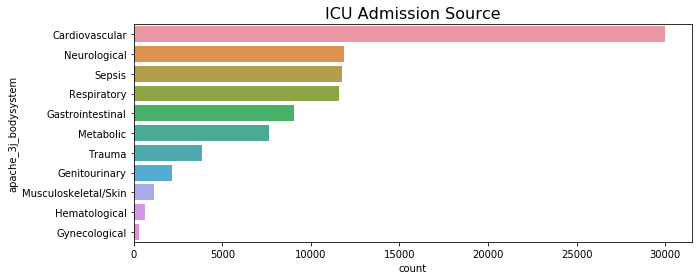

In [61]:
plt.figure(figsize=(10,4))
sns.countplot(y=train.apache_3j_bodysystem, order = train.apache_3j_bodysystem.value_counts().index)
plt.title("ICU Admission Source", fontsize=16)

### How mnay Hopsitals and ICUs?

In [65]:
train.hospital_id.nunique()

147

In [66]:
train.icu_id.nunique()

241

### Who needs LBG at 1st Hour?

Patients with Cardiovascular illness, the trend follows the overall bodysystem.

In [16]:
train[h1_lbg].isnull().sum()

h1_arterial_pco2_max    75959
h1_arterial_pco2_min    75959
h1_arterial_ph_max      76424
h1_arterial_ph_min      76424
h1_arterial_po2_max     75945
h1_arterial_po2_min     75945
h1_pao2fio2ratio_max    80195
h1_pao2fio2ratio_min    80195
dtype: int64

In [8]:
patients_h1_lbg = train.loc[train[h1_lbg].notnull().sum(axis=1)>0]

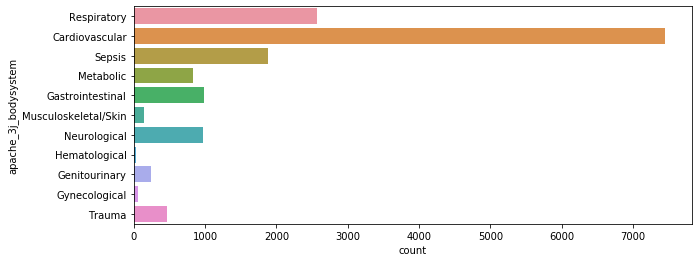

In [15]:
plt.figure(figsize=(10,4))
sns.countplot(y=patients_h1_lbg.apache_3j_bodysystem)

In [22]:
train.loc[train.apache_3j_bodysystem=='Cardiovascular',h1_lbg].isnull().sum()

h1_arterial_pco2_max    22569
h1_arterial_pco2_min    22569
h1_arterial_ph_max      22782
h1_arterial_ph_min      22782
h1_arterial_po2_max     22575
h1_arterial_po2_min     22575
h1_pao2fio2ratio_max    24267
h1_pao2fio2ratio_min    24267
dtype: int64

### What's the percentage of patietns who requires Invasive Ventilation?

In [35]:
train.ventilated_apache.astype(str).value_counts(normalize=True)

# 32%

0.0    0.669022
1.0    0.323182
nan    0.007796
Name: ventilated_apache, dtype: float64

### What's the percentage of patietns who requires Intubation?

In [36]:
train.intubated_apache.astype(str).value_counts(normalize=True)

# 15%

0.0    0.842160
1.0    0.150044
nan    0.007796
Name: intubated_apache, dtype: float64

### This is an unbalanced class problem - Hosptial death at 8.6%

In [ ]:
print(train.hospital_death.value_counts())
print()
print(train.hospital_death.value_counts(normalize=True))

### Quick look at the Distribution of some features to gain some insights

In [ ]:
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data = train, y = col,hue ='hospital_death')
    plt.title(col)
    plt.tight_layout()
    plt.show()

In [ ]:
train.groupby("gender").age.plot.hist(bins=74, alpha=0.5,figsize=(10,4))
plt.legend()
plt.xlabel("age")
plt.title("Patient's Distribution")
plt.show()

train.groupby("gender").weight.plot.hist(bins=74, alpha=0.5,figsize=(10,4))
plt.legend()
plt.xlabel('weight in kg')
plt.title("Patient's Distribution")
plt.show()

col = ['age', 'bmi', 'height', 'weight','pre_icu_los_days']
for i in col:
    train.groupby("hospital_death")[i].plot.hist(bins=74, alpha=0.3,figsize=(10,4))
    plt.legend()
    plt.title(i)
    plt.show()

In [ ]:
f_ave_death= train[train.gender=='F'][['age', 'hospital_death']].groupby('age').mean()
m_ave_death = train[train.gender=='M'][['age', 'hospital_death']].groupby('age').mean()
ave_death = pd.concat({"Female": f_ave_death,"Male": m_ave_death},axis=1)
ave_death.plot(figsize=(10,4))
plt.legend()
plt.title("Mortality Rate")

plt.show()

f_ave_death= train[train.gender=='F'][['weight', 'hospital_death']].groupby('weight').mean()
m_ave_death = train[train.gender=='M'][['weight', 'hospital_death']].groupby('weight').mean()
ave_death = pd.concat({"Female": f_ave_death,"Male": m_ave_death},axis=1)
ave_death.plot(figsize=(10,4))
plt.legend()
plt.title("Mortality Rate")

In [ ]:
#import plotly.express as px
#fig = px.histogram(train[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender",
#                   marginal="box", hover_data=train[['age','gender','hospital_death','bmi']].columns)
#fig.show()

## 4. Create a copy of train for Data Cleaning

In [ ]:
df = train.drop(columns=['encounter_id','patient_id','readmission_status']).reset_index(drop=True)
df.hospital_id = df.hospital_id.astype(str)
df.icu_id = df.icu_id.astype(str)

#df.apache_2_diagnosis = df.apache_2_diagnosis.astype(str)
#df.apache_3j_diagnosis = df.apache_3j_diagnosis.astype(str)
print(df.shape)

In [ ]:
# to confirm the columns are of the right datatype
categorical_cols = [col for col in df.columns if  (df[col].dtype != 'float64')&(df[col].dtype != 'int64') ]
print(len(categorical_cols))
categorical_cols

# Now ther are 10 categorical columns

## 5. Data Cleaning and more EDA
We have a large variety of variables, To approach the data cleaning in a systematic way, they were explored by datatypes and categories as shown below:

- 5.1 Data Cleaning and Imputation by Datatype - Categorical 
- 5.2 Data Cleaning and Imputation by Datatype - Binary
- 5.3 Data Cleaning and Imputation by Datatype - Numeric
    - A. Demographic columns
    - B. Vitals/labs Variables
    - C. Apache covariates columns
    - D. APACHE Unique Variables - indicator, chronic illness, and others

### Data Cleaning on Abnormal data from Previous observation

#### c. Negative apache_4a_hospital_death_prob, apache_4a_icu_death_prob
There are 2692 rows of data with negative probability values, which are all -1

These two probabilites are calculated based on APACHE IV scoring system, very likely they are proxy for NaN.  Leave them as it is.

In [ ]:
print(df[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob']].isnull().sum())
print(df[df.apache_4a_hospital_death_prob<0]['apache_4a_hospital_death_prob'].value_counts())
print(df[df.apache_4a_icu_death_prob<0]['apache_4a_icu_death_prob'].value_counts())

# Below code will convert -1 to NaN, but it create problem downstream for Logistic Regression.
#df.loc[df.apache_4a_hospital_death_prob<0,'apache_4a_hospital_death_prob'] = np.nan
#df.loc[df.apache_4a_icu_death_prob<0,'apache_4a_icu_death_prob'] = np.nan
#print(df[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob']].isnull().sum())

### 5.1 Data Cleaning and Imputation by Datatype - Categorical

**The following Variables were cleaned and deduced (whenever possible)**
- `apache_2_bodysystem`
- `apache_3j_diagnosis` ,`apache_3j_bodysystem`
- `icu_admit_source`
- `hospital_admit_source`

**Remaining missing Categorical data imputed with "Unknown" or equvalent**

In [ ]:
# Categorical columns
df[categorical_cols].isnull().sum()

In [ ]:
print(df.ethnicity.value_counts())
print()
print(df.hospital_admit_source.value_counts())
print()
print(df.icu_admit_source.value_counts())
print()
print(df.apache_3j_bodysystem.value_counts())
print()
print(df.apache_2_bodysystem.value_counts())

#### Observation and Approach:
* For categorical columns, it doesn't make sense to guess the value, plain "Unknown" is a better way than imputation.
* 6 columns have missing data, 6 have complete data.
* `ethnicity` already has a category of "Other/Unknown"
* `apache_2_bodysystem` have two categories with the difference of a letter(upper case vs lower case), they should be merged
* Will deduce `icu_admit_source` and `hospital_admit_source` based on other variables 
* For the rest that can't be impute, fill missing data with "Unknown" or an existing category equivalant to "unknown"

### `apache_2_bodysystem`

In [ ]:
df.apache_2_bodysystem.value_counts()

In [ ]:
# Fix `Undefined Diagnoses` and `Undefined diagnoses` values, merge these two into one
df.apache_2_bodysystem.replace("Undefined diagnoses", "Undefined Diagnoses", inplace=True)
df.apache_2_bodysystem.value_counts()

In [ ]:
df.apache_2_diagnosis.fillna(0).astype(str).map(lambda i: i.split('.')[1]).value_counts()

### `apache_3j_diagnosis` ,`apache_3j_bodysystem`
- The clean-up is based on [APACH-3j ICU codebook](https://www.kaggle.com/danofer/apache-iiij-icu-diagnosis-codes)
- No codebook available to explain apache_2_diagnosis, for now will not consider this variable
- Between diagnosis and bodysystem, the carry smiliar information.  The only difference is that diagnosis has more details.  We can choose to use either one and leave out the other.  For now, suggest to keep bodysystem.
- diagnosis is coded, it should be treated as categorical.

#### Invalid diagnosis

In [ ]:
#print(test['apache_3j_diagnosis'].value_counts())
print("Number of missing 3j diagnosis: ", df.apache_3j_diagnosis.isnull().sum())
print("Number of invalid 3j diagnosis: ",len(df[df.apache_3j_diagnosis<101]))
print("Number of missing 3j bodysystem: ",df.apache_3j_bodysystem.isnull().sum())
      
#print(test[test['apache_3j_diagnosis']<101]['apache_3j_diagnosis'].value_counts())
print(df[df['apache_3j_diagnosis']<101]['apache_3j_diagnosis'])

# There are 561 patients with invalid diagnosis code (<101), 1101 missing diagnosis, 
# Totalling 1662, the same number of patients with missing bodysystem data.  
# This is because the bodysystem is derived from the diagnosis.

# There doesn't seem to have a way to deduce the bodysystem from by looking at the decimal points alone
# Will treat them as NaN.

#### <font color = 'blue'> SUBSTITUTE </font>invalid `apache_3j_diagnosis` to NaN first, then to 0 with other NaN next

In [ ]:
index = [i for i in df.index if df.loc[i,'apache_3j_diagnosis']<101]
df.loc[index,'apache_3j_diagnosis'] = np.nan
df['apache_3j_diagnosis'].isnull().sum()

#### <font color = 'blue'> IMPUTING </font> bodysystems and diagnosis 

In [ ]:
df.apache_3j_bodysystem = df.apache_3j_bodysystem.fillna("Unknown")
df.apache_2_bodysystem = df.apache_2_bodysystem.fillna("Unknown")
df.apache_3j_diagnosis = df.apache_3j_diagnosis.fillna(0)
df.apache_2_diagnosis = df.apache_2_diagnosis.fillna(0)

# Verify no more missing data
print(df.apache_3j_bodysystem.isnull().sum())
print(df.apache_3j_diagnosis.isnull().sum())

# Verify no more invalid 3j diagnosis
print(df[(df['apache_3j_diagnosis']<101)&(df['apache_3j_diagnosis']>0)]['apache_3j_diagnosis'])

# Create new varible to group patients by 3j diagnosis' main diagnosis (ignore the sub-diagnosis - decimals)
# Create new variable to group patients by 3j diagnosis' main diagnosis (by illness type - e.g 1xx, 11xx)?
# Create new variable to indicate if a patient has gone through operation (4 digits and starting at 1202: operative)
#                        use it to verify if variable apache_post_operative matches
#                        use it to verify if variable icu_admit_source matches


df['apache_3j_diag_int'] = df['apache_3j_diagnosis'].fillna(0).astype(str).map(lambda i: i.split('.')[0])
df['apache_3j_diag_type'] = df['apache_3j_diag_int'].map(lambda i: i[:-2])  # discard the last 2 digits
df['apache_3j_diag_operative'] = df['apache_3j_diag_int'].astype(int).map(lambda i: 1 if i>=1202 else 0)  # code >= 1202 is operative

df[df['apache_3j_diag_operative'] != df.apache_post_operative][['apache_post_operative','apache_3j_diagnosis','apache_3j_diag_int','apache_3j_diag_operative']]

### `icu_admit_source`
- Use `apache_post_operative` to deduce missing values
- Impute the rest with "Unknown"

In [ ]:
print(df.icu_admit_source.astype(str).value_counts())
print()

df.loc[(df['apache_post_operative']==1) & (df['icu_admit_source'].isnull()),'icu_admit_source'] = 'Operating Room / Recovery'
df.icu_admit_source = df.icu_admit_source.fillna("Unknown")

print(df.icu_admit_source.astype(str).value_counts())

### `hospital_admit_source`

In [ ]:
df.hospital_admit_source.value_counts()

Consolidate sources:
* Recovery Room and Observation are same as 'PACU'- Post Anaesthesia Care Unit
* ICU to SDU and Step-Down Unit (SDU) to combine
* Suspect `Other Hospital`, `Other ICU` and `ICU` refer to the same source, as "Other Hospital"?
* Acute Care/Floor to Acute Care to avoid confusion with Floor

In [ ]:
df.hospital_admit_source.replace({"PACU": 'Recovery Room',
                                  "Observation": "Recovery Room",
                                  "ICU to SDU": "SDU",
                                  "Step-Down Unit (SDU)": "SDU",
#                                  "Other ICU": "Other Hospital" ,
#                                  "ICU": "Other Hospital" ,
                                  "Acute Care/Floor": "Acute Care"}, inplace = True)
df.hospital_admit_source.value_counts()

In [ ]:
print(df.hospital_admit_source.isnull().sum())
print(df.icu_admit_source.isnull().sum())

In [ ]:
# Create a new variable to look at the admission flow
loc_map = {"Emergency Department": "A&E",
          "Accident & Emergency": "A&E",
          "Recovery Room": "Recovery",
           "Operating Room": "OR",
           "Operating Room / Recovery": "OR-recovery"
          }
df['admit_flow'] = df.hospital_admit_source.astype(str).replace(loc_map) + "_" + df.icu_admit_source.astype(str).replace(loc_map)
admit_flow_counts = df.admit_flow.value_counts().sort_index()

In [ ]:
row = [i for i in admit_flow_counts.index if i.startswith("OR")]
admit_flow_counts[row]

In [ ]:
# OR_nan has 9 rows, are these patients admitted to hospital prior to ICU admission?
df[(df.admit_flow == 'OR_nan') & (df['pre_icu_los_days']>0)].shape

# All 9 has positive pre_icu_los_days, so yes.  
# Based on the flow above, majority patients who were admitted to hospital due to Operation, will go to OR_recovery, then ICU
# Will fill nan of these 9 patients with Operating Room / Recovery

#### Can we deduce the missing data in `hospital_admit_source` using `admit_flow` ?
Looking at the admission flow, try to impute bsed on deduction

- nan_A&E               12621  -> Impute with Emergency Department 
- nan_Floor              4014
- nan_OR-recovery         575  -> Impute with Operating Room 
- nan_Other Hospital      671  -> Impute with Other Hospital
- nan_Other ICU           163
- nan_nan                 103

In [ ]:
row = [i for i in admit_flow_counts.index if i.startswith("nan")]
admit_flow_counts[row]

In [ ]:
admit_flow_counts.sort_values(ascending=False)

In [ ]:
row = [i for i in admit_flow_counts.index if i.startswith("A&E")]
admit_flow_counts[row]

In [ ]:
# For admit_flow == 'nan_A&E'
print(df[(df.admit_flow == 'nan_A&E') & (df['pre_icu_los_days']>=0)].shape)
print(df[(df.admit_flow == 'nan_A&E') & (df['pre_icu_los_days']<0)].shape)

# majority of the patients (12223) who were admitted to hospital due to Operation.  They will go to OR_recovery, then ICU
# For those who were admitted to ICU prior to admission to hospital (not quite sure how that could happen), natual to take the hospital source to be A&E
row = [i for i in admit_flow_counts.index if i.endswith("A&E")]
admit_flow_counts[row]

In [ ]:
# For admit_flow == 'nan_Floor'
print(df[(df.admit_flow == 'nan_Floor') & (df['pre_icu_los_days']>=0)].shape)
print(df[(df.admit_flow == 'nan_Floor') & (df['pre_icu_los_days']<0)].shape)
row = [i for i in admit_flow_counts.index if i.endswith("Floor")]
admit_flow_counts[row]

# not conclusive answer from the observation below

In [ ]:
# For admit_flow == 'nan_OR-recovery'
print(df[(df.admit_flow == 'nan_OR-recovery') & (df['pre_icu_los_days']>=0)].shape)
print(df[(df.admit_flow == 'nan_OR-recovery') & (df['pre_icu_los_days']<0)].shape)
row = [i for i in admit_flow_counts.index if i.endswith("OR-recovery")]
admit_flow_counts[row]

# only OR_OR-recovery seems legit (reasoble flow) to me, will fillna with OR

In [ ]:
# For admit_flow == 'nan_Other Hospital'
print(df[(df.admit_flow == 'nan_Other Hospital') & (df['pre_icu_los_days']>=0)].shape)
print(df[(df.admit_flow == 'nan_Other Hospital') & (df['pre_icu_los_days']<0)].shape)
row = [i for i in admit_flow_counts.index if i.endswith("Other Hospital")|i.startswith("Other Hospital")]
admit_flow_counts[row]

# Other Hospital_Other Hospital is the mode, fillna with Other Hospital

In [ ]:
# For admit_flow == 'nan_Other ICU'
print(df[(df.admit_flow == 'nan_Other ICU') & (df['pre_icu_los_days']>=0)].shape)
print(df[(df.admit_flow == 'nan_Other ICU') & (df['pre_icu_los_days']<0)].shape)
row = [i for i in admit_flow_counts.index if i.endswith("Other ICU")]
admit_flow_counts[row]

# no conclusive solution

#### Solution to: Can we deduce the missing data in hospital_admit_source?
The admission flow is extremely messy.  I don't have indepth understanding on this perspective, but if a patients visits A&E, and requires further treatment, hospital admission supposingly occurs at A&E, then move on to other department, and redirect to ICU when intensive treament is needed. However there are too many combination and I couln't make sense out of them.  One possible answer is that different hospitals could have different way of reporting, and possibly the time when hopsital admission occurs could be at a later stage, rather than my assumption of "hospital admission prior to admission to ICU", i.e. expecting pre_icu_los_days to be positive.

so the following flow seem to be wrong:

- A&E_Other Hospital          59
- Acute Care_A&E              30
- Chest Pain Center_A&E        4
- Direct Admit_A&E          5749
- Floor_A&E                  108
- ICU_A&E                      8
- OR_A&E                     197
- Other Hospital_A&E          71
- Other ICU_A&E                4
- Other_A&E                    1
- Recovery_A&E                70
- SDU_A&E                      4
- nan_A&E                  12621

Conclusion:
* Patient with elective_surgery (scheduled surgery): their hospital addmision reason should be "Operating Room"* 
* Majority patients who were admitted to hospital due to Operation, general subsequent flow would be: OR_recovery, then ICU --> impute icu_admit_source to be OR
* Majority of the patients were admitted to hospital/ICU from A&E, if one source is A&E, the other source is missing, will impute the missing one to A&E too.
* for nan_OR-recovery flow: fillna with "Operating Room"
* for nan_Other Hospital flow: fillna with the most likely choice of Other Hospital

In [ ]:
print(df.hospital_admit_source.isnull().sum())
df.loc[(df.hospital_admit_source.isnull()) & (df.elective_surgery==1),'hospital_admit_source'] = 'Operating Room'
df.loc[df.admit_flow=="OR_nan","icu_admit_source"] = 'Operating Room / Recovery'
df.loc[df.admit_flow == 'nan_A&E',"hospital_admit_source"] = 'Emergency Department'
df.loc[df.admit_flow == 'nan_OR-recovery',"hospital_admit_source"] = 'Operating Room'
df.loc[df.admit_flow == 'nan_Other Hospital',"hospital_admit_source"] = 'Other Hospital'
print("Remaining null rows: ",df.hospital_admit_source.isnull().sum())
print(df.icu_admit_source.isnull().sum())

#### IMPUTING the remaining missing Categorical data with "Unknown" or equvalent

In [ ]:
df.ethnicity = df.ethnicity.fillna("Other/Unknown")
df.gender = df.gender.fillna("Unknown")
df.hospital_admit_source = df.hospital_admit_source.fillna("Unknown")
df.icu_admit_source = df.icu_admit_source.fillna("Unknown")
#df.apache_3j_bodysystem = df.apache_3j_bodysystem.fillna("Unknown")
#df.apache_2_bodysystem = df.apache_2_bodysystem.fillna("Unknown")

### Categorical Variables After Cleanup and Imputation

In [ ]:
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data = df, y = col,hue ='hospital_death')
    plt.title(col)
    plt.tight_layout()
    plt.show()

### 5.2 Data Cleaning and Imputation by Datatype - Binary

In [ ]:
bi_cols = ['hospital_death','elective_surgery','gcs_unable_apache'] + apache_indicators + apache_chronic
print(len(bi_cols))

In [ ]:
for col in bi_cols:
    print(df[col].astype(str).value_counts())
    print()

**Missingness:**
- Apache related columns have the same number of missing rows: 715. That means they could come from the same patients
- `gcs_unable_apache` has 1037 missing rows

Codes below is to check on those missingness:

In [ ]:
#df.elective_surgery.value_counts(normalize=True)

In [ ]:
#df.apache_post_operative.value_counts(normalize=True)

In [ ]:
# check if the 715 patients were systematically missing these info
col = ['arf_apache', 'intubated_apache', 'ventilated_apache'] + apache_chronic   # 11 binary variables from above
df[df[col].isnull().sum(axis=1) == len(col)].shape

# 715 rows returned, so they are missing the binary apache data systematically

In [ ]:
# take a look at these patients
#df[df[col].isnull().sum(axis=1) == len(col)]

In [ ]:
#index = df[df[col].isnull().sum(axis=1) == len(col)].index
#df.loc[index,apache].isnull().sum()

* Confirmed that these patients are missing all APACHE measurements except the diagnosis and bodysystem. 
* <font size = 3 color = "crimson">Come back to address APACHE later</font>

#### Missing `gcs_unable_apache`

In [ ]:
df[df[gcs].isnull().sum(axis=1) == len(gcs)].shape

In [ ]:
# check if all gcs columns are systematic missing data
df[(df.gcs_unable_apache.isnull()) & 
   (df.gcs_eyes_apache.isnull()) & 
   (df.gcs_motor_apache.isnull()) & 
   (df.gcs_verbal_apache.isnull())].shape

> the number of patients with gcs_unable_apache = NaN is the same as those with eye/motor/verbal all missing

> It seems like these 1037 patients are under sedation (hence couldn't get GCS assessed).  Code below to prove this suspection

In [ ]:
# For patients under sedation (gcs_unable_apache==1), are their eyes/motor/verbal scores all missing? 
sedated= df[df.gcs_unable_apache==1]
print(len(sedated))
print(len(sedated[(sedated.gcs_eyes_apache.isnull()) & 
                  (sedated.gcs_motor_apache.isnull()) & 
                  (sedated.gcs_verbal_apache.isnull())]))

> Yes, eyes/motor/verbal scores are all missing for sedated patients 

In [ ]:
# For non-sedated patients(gcs_unable_apache==0), is there any missing data in eyes/motor/verbal scores? 
nonsedated= df[df.gcs_unable_apache==0]
print(len(nonsedated))
print(len(nonsedated[(nonsedated.gcs_eyes_apache.isnull()) | 
                     (nonsedated.gcs_motor_apache.isnull()) |
                     (nonsedated.gcs_verbal_apache.isnull())]))

> No, eyes/motor/verbal scores are all available for non-sedated patients 

> So we should treat these 1037 patients as sedated ones

#### <font color = 'blue'> IMPUTING </font> missing `gcs_unable_apache` with 1 (treated as sedated patients)

In [ ]:
# Before
print(df.gcs_unable_apache.astype(str).value_counts())

# Fill the missing rows with 1
df.gcs_unable_apache.fillna('1.0',inplace=True)

# After
print(df.gcs_unable_apache.astype(str).value_counts())

### Data Cleaning and Imputation by Datatype - Numerical
    - A. Demographic columns
    - B. Vitals/labs Variables
    - C. Apache covariates columns
    - D. APACHE Unique Variables - indicator, chronic illness, and others

#### A. Demographic columns
The following variables were treated: 
- Negative `pre_icu_los_days`
- Impution for `height`, `weight`, and `age`.  Calcuate bmi from 'weight' and 'height'     

In [30]:
df[demographic].isnull().sum()

NameError: name 'df' is not defined

#### Negative `pre_icu_los_days`

In [ ]:
print(df.pre_icu_los_days.min())
df[df.pre_icu_los_days<0]

# 778 of patients with negative LOS days.
# Where do these patients come from? What is the ICU type they stayed?

In [ ]:
plt.figure(figsize=(10,4))
plt.hist(df[df.hospital_death==1].pre_icu_los_days,bins=100,alpha=0.6, label='hospital_death==1',density=True)
plt.hist(df[df.hospital_death==0].pre_icu_los_days,bins=100,alpha=0.6, label='hospital_death==0',density=True)
plt.legend()

In [ ]:
sns.countplot(y=df[df.pre_icu_los_days<0].icu_admit_source, hue=df.hospital_death)
plt.show()
sns.countplot(y=df[df.pre_icu_los_days<0].icu_type, hue=df.hospital_death)

# Majority comes from A&E, staying in the Med-Surg ICU
# Without admission date details, can't correct these.
# Since Test dataset shows the same issue -  will leave it as it is

#### Impution for `height`, `weight`, and `age`.  Calcuate bmi from 'weight' and 'height'                      

#### Impute height and weight

In [ ]:
df.groupby("gender").height.plot.hist(bins=8, alpha=0.3, density=True)
plt.axvline(df[df["gender"]=='M'].height.median(), color = 'r',linestyle='dashed')
plt.axvline(df[df["gender"]=='F'].height.median(), color = 'b',linestyle='dashed')
plt.axvline(df[df["gender"]=='Unknown'].height.median(), color = 'g',linestyle='dashed')
plt.legend()
plt.title("Height Distribution")

In [ ]:
df.groupby("gender").weight.plot.hist(bins=8, alpha=0.5, density=True)
plt.axvline(df[df["gender"]=='M'].weight.median(), color = 'r',linestyle='dashed')
plt.axvline(df[df["gender"]=='F'].weight.median(), color = 'b',linestyle='dashed')
plt.axvline(df[df["gender"]=='Unknown'].weight.median(), color = 'orange',linestyle='dashed')
plt.legend()
plt.title("Weight Distribution")

In [ ]:
male = df[df.gender == 'M']
male_height_null_index = male[male.height.isnull()].index
male_weight_null_index = male[male.weight.isnull()].index

In [ ]:
w_median = {}
w_median['F'] = df[df["gender"]=='F'].weight.median()
w_median['M'] = df[df["gender"]=='M'].weight.median()
w_median['Unknown'] = df[df["gender"]=='Unknown'].weight.median()

h_median = {}
h_median['F'] = df[df["gender"]=='F'].height.median()
h_median['M'] = df[df["gender"]=='M'].height.median()
h_median['Unknown'] = df[df["gender"]=='Unknown'].height.median()
print(w_median, h_median)

In [ ]:
for sex in df.gender.unique():
    print(sex)
    gender = df[df.gender == sex]
    height_null_index = gender[gender.height.isnull()].index
    weight_null_index = gender[gender.weight.isnull()].index
    print(df.loc[height_null_index].height.head())
    print(df.loc[weight_null_index].weight.head())
    df.loc[height_null_index,'height'] = df.loc[height_null_index,'height'].fillna(h_median[sex])
    df.loc[weight_null_index,'weight'] = df.loc[weight_null_index,'weight'].fillna(w_median[sex])
    print(df.loc[height_null_index].height.head())
    print(df.loc[weight_null_index].weight.head(10))

#### Calculate bmi for missing rows

In [ ]:
bmi_null_index = df[df.bmi.isnull()].index
df.loc[bmi_null_index].head()

In [ ]:
# kilograms/metres^2, weight/(height/100)**2
df.loc[bmi_null_index, 'bmi'] = df.loc[bmi_null_index, 'bmi'].fillna(round(df.weight/(df.height/100)**2,2))

In [ ]:
df.loc[bmi_null_index].head()

In [ ]:
df.height.plot.hist(figsize=(10,4))
plt.xlabel('Height (cm)')
plt.show()
df.weight.plot.hist(figsize=(10,4))
plt.xlabel('Weight (kg)')
plt.show()
df.bmi.plot.hist(figsize=(10,4))
plt.xlabel('bmi')

In [ ]:
df[demographic].isnull().sum()

#### Impute Age with fillna(0)

In [ ]:
df.age.plot.hist(figsize=(10,4))

In [ ]:
age_null_index = df[df.age.isnull()].index
df.loc[age_null_index].head()

In [ ]:
df.loc[age_null_index,'age'] = df.loc[age_null_index,'age'].fillna(0)
#df.loc[age_null_index,'age'] = df.loc[age_null_index,'age'].fillna(df.age.median())
df.loc[age_null_index].head()

### B. Vitals/labs Variables

The following was done for Numerical Vitals/Labs Variables
1. Fix the data when max < min
2. Explore if `h1` data can be used to fill up `d1`
3. Understand the different varieties of blood pressure measurements.  
 - Fix the data according to data dictionary's definition
 - Explore if missing mean BP can be imputed based on formula

### Sanity check if data in '_max' col is always equal or larger than '_min'.  If they are not, fix it

In [ ]:
# Extract test name without suffix of '_min' or '_max'
cols = list(set([col[:-4] for col in df.columns if (col.endswith("_min"))| (col.endswith("_max"))]))
len(cols)

In [ ]:
# Fix elements where max < min
count = 0
for col in cols:
    deta = []
    index = []
    temp = []
    min = col + "_min"
    max = col + "_max"
    delta = (df[max]-df[min])
    index = delta[delta<0].index    # index for patients with MAX < MIN

    temp = df.loc[index,max]                # Store the original max value away
    df.loc[index,max] = df.loc[index,min]   # place the min value into the _max column
    df.loc[index,min] = temp                # place the original max value into the _min column

    if delta.min()<0:
        count +=1
        print(df.loc[index,[max,min]])
print("Total number of tests with Max<Min: ",count)

In [ ]:
print(df[d1_vitals].isnull().sum())
print(df[h1_vitals].isnull().sum())

> comparison between h1 and d1: per measurement, h1 has more missing rows than d1
> Invasive data is more sparse than noninvasive
> Imputation doesn't make sense, as we are making up the measurement for patients if we do so. But in order for the model to run, we have to.

### Can we  use h1 data to fill d1 data
For every test, is there any patients that has h1 data but not d1 data? if so, we will impute d1 data with h1.

In [ ]:
h1_cols = [col for col in df.columns if col.startswith("h1_")]

# Extract variable names without the prefix of h1 or d1
variable = [col[2:] for col in h1_cols]
for i in variable:
    pair = [col for col in df.columns if col.endswith(i)]
    print(df.loc[(df[pair[0]].isnull()) &(df[pair[1]].notnull()),pair])

No luck.  For every test, if d1 data is missing, h1 data is also missing.

#### Blood Pressure - An vital that takes up 36 columns for First hour and First Day alone
18 variables x 2 (h1, d1), blood pressure can be divided into 3 groups:
- invasive (systolic, mean, diastolic)
- noninvasive (systolic, mean, diastolic)
- worst (systolic, mean, diastolic)

Based on data dictionary: the worst should be either the highest reading (_max), or the lowest reading (_min) of the invasive and noninvasive measurement

**Summary:** 
- As shown below, <font color='blue'> _diasbp/_sysbp/_mbp's min/max are taken from noninvasive measurements or invasive (if noninvasive is not available) </font>
- When invasive and noninvasive measurement are not available, the 3rd group (worst) have no data either
- Worst BP measurements are messy.  Some worst measurement were not recorded according to definition.  We can manually assign it to fix the prob
- Explore the likelihood to impute missing mean BP based on formula, but the calculated results don't seem to be a very good fit, without further information, will leave it as it is.

In [ ]:
h1 = df[h1_vitals]
d1 = df[d1_vitals]
d1[d1.d1_sysbp_invasive_min.notnull()]

> Visually inspected, for blood pressure, the mean (such as h1_sysbp_, d1_diasbp_, d1_mbp_) was taken from the noninvasive.
> Below is to verify if this is true for the whole dataset

In [ ]:
# d1_diasbp
print("Number of rows of missing diasbp_max : ", len(d1[(d1.d1_diasbp_max.isnull())]))
print("Number of rows for missing diasbp measurments (all 6) : ",len(d1[(d1.d1_diasbp_max.isnull()) & (d1.d1_diasbp_min.isnull()) & 
   (d1.d1_diasbp_noninvasive_max.isnull()) & (d1.d1_diasbp_noninvasive_min.isnull())& 
   (d1.d1_diasbp_invasive_max.isnull()) & (d1.d1_diasbp_invasive_min.isnull())]))

# d1_sysbp
print("Number of rows of missing sysbp_max : ", len(d1[(d1.d1_sysbp_max.isnull())]))
print("Number of rows for missing sysbp measurments (all 6) : ",len(d1[(d1.d1_sysbp_max.isnull()) & (d1.d1_sysbp_min.isnull()) & 
   (d1.d1_sysbp_noninvasive_max.isnull()) & (d1.d1_sysbp_noninvasive_min.isnull())& 
   (d1.d1_sysbp_invasive_max.isnull()) & (d1.d1_sysbp_invasive_min.isnull())]))

# d1_mbp
print("Number of rows of missing mbp_max : ", len(d1[(d1.d1_mbp_max.isnull())]))
print("Number of rows for missing mbp measurments (all 6) : ",len(d1[(d1.d1_mbp_max.isnull()) & (d1.d1_mbp_min.isnull()) & 
   (d1.d1_mbp_noninvasive_max.isnull()) & (d1.d1_mbp_noninvasive_min.isnull())& 
   (d1.d1_mbp_invasive_max.isnull()) & (d1.d1_mbp_invasive_min.isnull())]))


# h1_diasbp
print("Number of rows of missing h1_diasbp_max : ", len(h1[(h1.h1_diasbp_max.isnull())]))
print("Number of rows for missing h1_diasbp measurments (all 6) : ",len(h1[(h1.h1_diasbp_max.isnull()) & (h1.h1_diasbp_min.isnull()) & 
   (h1.h1_diasbp_noninvasive_max.isnull()) & (h1.h1_diasbp_noninvasive_min.isnull())& 
   (h1.h1_diasbp_invasive_max.isnull()) & (h1.h1_diasbp_invasive_min.isnull())]))


> Missing data is systematic at diasbp/sysbp/mbp's min and max
> diasbp/sysbp/mbp's min and max are missing due to no measurements (noninvasive and invasive are both not available)

#### Blood Pressure: Trying to make sense with different varieties

In [ ]:
# How many rows of diasbp (min and max) agree with noninvasive measurements
print(h1[(h1.h1_diasbp_max == h1.h1_diasbp_noninvasive_max) & 
         (h1.h1_diasbp_min == h1.h1_diasbp_noninvasive_min)].shape)

# How many rows of diasbp (min and max) agree with invasive measurements
print(h1[(h1.h1_diasbp_max == h1.h1_diasbp_invasive_max) & 
         (h1.h1_diasbp_min == h1.h1_diasbp_invasive_min)].shape)

In [ ]:
h1[(h1.h1_diasbp_max == h1.h1_diasbp_invasive_max) & (h1.h1_diasbp_min == h1.h1_diasbp_invasive_min) & 
   (h1.h1_diasbp_noninvasive_max.isnull()) & (h1.h1_diasbp_noninvasive_min.isnull())].shape

In [ ]:
h1[(h1.h1_diasbp_max == h1.h1_diasbp_invasive_max) & (h1.h1_diasbp_min == h1.h1_diasbp_invasive_min) & 
   (h1.h1_diasbp_noninvasive_max.notnull()) & (h1.h1_diasbp_noninvasive_min.notnull())].shape

- Majority ofth mean bp come from noninvasive measurement, 

- Minority come from invasive, which is largely due to missing data in the noninvasive cols

#### Blood Pressure: for those reading taken from INVASIVE, while noninvasive is still present, why is noninvasive reading not taken into account?

It seems that some were taken correctly (choose the highest/lowest from noninvasive/invasive), some were wrong (human error?)

In [ ]:
# mean bp taken from invasive while noninvasive meausurements are still present
# it seems that the the noninvasive measurement was only taken once (hence max=min)
h1[(h1.h1_diasbp_max == h1.h1_diasbp_invasive_max) & (h1.h1_diasbp_min== h1.h1_diasbp_invasive_min) & 
   (h1.h1_diasbp_noninvasive_max.notnull()) & (h1.h1_diasbp_noninvasive_min.notnull())]

In [ ]:
h1[(h1.h1_diasbp_max == h1.h1_diasbp_invasive_max) & (h1.h1_diasbp_min== h1.h1_diasbp_invasive_min) & 
   (h1.h1_diasbp_noninvasive_max.notnull()) & (h1.h1_diasbp_noninvasive_min.notnull()) & (h1.h1_diasbp_noninvasive_max != h1.h1_diasbp_noninvasive_min)]

#### Blood Pressure: How well does the calculated MAP compared to the data?
** MAP = (sbp + 2*dbp)/3** for each of the 6 measurements

In [ ]:
d1 = df[d1_vitals]

d1['map_max'] = (d1['d1_sysbp_max'] + 2*d1['d1_diasbp_max'])/3
diff_max = d1['d1_mbp_max'] - d1['map_max']

map_min = (d1['d1_sysbp_min'] + 2*d1['d1_diasbp_min'])/3
diff_min = d1['d1_mbp_min'] - map_min

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y=diff_min, x=df['d1_mbp_min'],alpha=0.5)
plt.axhline(0, color = "g", linestyle = 'dashed')
plt.ylabel("Difference")
plt.xlabel("Actual d1_mbp_min")

plt.figure(figsize=(8,8))
plt.scatter(y=diff_max, x=df['d1_mbp_max'],alpha=0.5)
plt.axhline(0, color = "g", linestyle = 'dashed')
plt.ylabel("Difference")
plt.xlabel("Actual d1_mbp_max")

#plt.figure(figsize=(8,8))
#plt.scatter(map_max, df['d1_mbp_max'],alpha=0.5)
#plt.xlabel("Calucated Day 1 Mean Arterial Pressure (Max)")
#plt.ylabel("Actual d1_mbp_max")

>The calculated value doesn't seem to be a very good fit

#### Blood Pressure: Assign the worse measurement based on invasive and noninvasive values
<font color='orange'>This change has NOT commited to the main dataframe yet. </font>

In [ ]:
col = ['h1_diasbp', 'h1_sysbp', 'h1_mbp', 'h1_diasbp', 'h1_sysbp', 'h1_mbp']
col

In [ ]:
# Create a copy of the dataframe
temp = df.copy(deep=True)

for i in col:
# Max
    invasive = i + "_invasive_max"
    noninvasive = i + '_noninvasive_max'
    worse = i + "_max"
    temp[worse] = np.fmax(temp[invasive], temp[noninvasive])  # take the row-wise maximum
    
# Min
    invasive = i + "_invasive_min"
    noninvasive = i + '_noninvasive_min'
    worse = i + "_min"
    temp[worse] = np.fmin(temp[invasive], temp[noninvasive])  # take the row-wise minimum

temp.head()

### C. Apache covariates columns
* Missing Apache Covariates can be imputed based on the codebook instruction, but it's going to be a very tedious process
* And it won't impute all missing rows - only if h1_, and d1_ data is available - <font color = "crimson">so we still have a lot of them missing</font>
* What's the point of reconstrucing the Apache reading, while most of them arealready in the h1_, d1_ variables?
* Instead, <font color = "crimson">reconstructing Apache score may be more meaningful for prediction</font> - they can be provided with the dataset but wasn't, why?
* If you compute the Apache score, you're actually following the APACHE 3j scoring system to rank a patient, then how is this prediction different from the already established scoring system?  
         - It's different in the sense of the formula
         - It means you recogize the usefulness of the score, and use them as part of the predictors
* <font color='green'>__Will come back and work on the score construction if time permits, skip for now__</font>

In [ ]:
print(len(apache_cov))
apache_cov_df = df[apache_cov]
apache_cov_df.isnull().sum()

In [ ]:
d1_labs_df = df[d1_labs]
d1_labs_df.isnull().sum()

#### BUN
- By definition: `bun_apache` is the bun(blood urea nitrogen concentration) measured during the first 24 hours which results in the highest APACHE III score. It's expected that `bun_apache`is taken from `d1_bun_max`

- Verified results shows that they are highly matched in most cases, but there are some observations that don't.
- Impute missing `bun_apache`using `d1_bun_max` or we just remove this col (since redundant)

In [ ]:
bun_col = [i for i in df.columns if 'bun' in i]
#bun_col.remove('bun_to_creatinine')
df[bun_col].plot.line(alpha=0.5,figsize=(14,4))

In [ ]:
sns.regplot(df.bun_apache, df.d1_bun_max)

#### <font color = 'blue'> IMPUTING: </font> We'll use `d1_bun_max` to impute `bun_apache` anyway

In [ ]:
index = df[df.bun_apache.isnull()].index
index = df[df.bun_apache.isnull()].index
df.loc[index,'bun_apache'] = df.loc[index,'d1_bun_max']
#df.loc[index,['bun_apache','d1_bun_max']]

df.bun_apache.isnull().sum()

# Missing value reduced from 19262 to 9762

### D. APACHE Unique Variables - indicator, chronic illness, and others
The following unique Variables were explored to see how best we can make deduction
1. `arf_apache`
2. `fio2_apache`

#### 1. Can we  impute `arf_apache` from other Variables?
* From Data Dictionary: *ARF (Acute Renal Failure): 24 hour urine output <410ml, creatinine >=133 micromol/L (1.5mg/dL) and no chronic dialysis*
* Missing arf_apache came from the 715 patients who don't have any APACHE results, hence `urineoutput_apache` will be missing too
* Conclusion:  **Unable to impute**
* However, based on the observation, the creatinine unit is not as what described, suspect the unit is in mg/dL, however the observation doesn't filfull this either( min creatinine for arf patients is at 0.3 units

In [ ]:
train.arf_apache.astype(str).value_counts()

# 2546 patients have ARF according to this variable

In [ ]:
# Explore the urine output and creatinine values for thos ARF patients
train.loc[(train.arf_apache==1)&(train.urineoutput_apache.notnull()), ["urineoutput_apache","d1_creatinine_max","creatinine_apache"]]

# The data doesn't tally with the criteria (creatinine level>=133)

In [ ]:
train.d1_creatinine_max.plot.hist()
plt.legend()
plt.title("d1_creatinine_min")
plt.show()
train.creatinine_apache.plot.hist()
plt.title("creatinine_apache")

> Normal creatinine range: 60 to 110 μmol/L (0.7 to 1.2 milligrams per deciliter (mg/dL)) for men

>                      45 to 90 μmol/L (0.5 to 1.0 mg/dL) for women.

> None of the patients has creatinine exceeding 12 (the unit is micromol/L according to the data dictionary), but the range of data shown in the histogram is disordant.  We should see data in the scale of 100s, but we have (0,12).  Should the unit be mg/dL?

In [ ]:
train[train.arf_apache==0]['creatinine_apache'].plot.hist(density=True,alpha=0.5,label='arf_apache=0',bins=50)
train[train.arf_apache==1]['creatinine_apache'].plot.hist(density=True,alpha=0.5,label='arf_apache=1',bins=50)
plt.legend()
plt.title("creatinine_apache")
print("Minimum creatinine level for arf patient is:", train[train.arf_apache==1]['creatinine_apache'].min())

In [ ]:
train.urineoutput_apache.plot.hist(alpha=0.5)
plt.axvline(410)

#### 2. Can we impute `fio2_apache` based on other Variables?
`fio2_apache` (Permissible range: 0.21 – 1.00) (codebook Pg82)
   - For patients with assisted breathing, the FiO2 is read from the controlled oxygen source
   - For patients breathing unassisted i.e. room air, the FiO2 is recorded as 0.21.
   
Conclusion: 
* After exploring the relationship among `d1_pao2fio2ratio_xx`, `fiO2_apache` and `d1_arterial_po2_xx`, **decided NOT to pursue imputation for `fio2_apache`**, because the value of `d1_pao2fio2ratio_xx` doesn't seem to be relable

In [ ]:
# We can use xx__arterial_po2_xx and xx _pao2fio2ratio_xx to impute fiO2

print('Number of patients with Fio2 is at room air level: ',len(df[df.fio2_apache==0.21]))
print('Number of missing fio2_apache:', df.fio2_apache.isnull().sum())
print('Number of missing d1_arterial_po2_max:',df.d1_arterial_po2_max.isnull().sum())
print('Number of missing d1_pao2fio2ratio_max:',df.d1_pao2fio2ratio_max.isnull().sum())
#df.fio2_apache.plot.hist(bins=90,figsize=(10,4))
#plt.title('Distribution of fio2_apache')

### `pao2fio2ratio`
- There is an error in the data dictionary.  The unit of the following 4 variables is not fraction, the typical value is not 0.21 either.
- pao2fio2ratio is the ratio of PaO2/FiO2. **The medical serverity increases as the resulting value decreases.** - the `xx_pao2fio2ratio_min` is of interests.
- A normal person breathing room air (FiO2 = 0.21), whose PaO2 is approximately 100 mm Hg, would have a PaO2/FiO2 ratio of approximately 500 [source](https://www.aafp.org/afp/2002/0501/p1823.pdf)
- Acute lung injury is present if PaO2/FiO2 ratio is ≤ 300*
- Acute respiratory distress syndrome is present if PaO2/FiO2 ratio ≤ 200

- Most healthy adults have a PaO2 within the normal range of 80–100 mmHg. If a PaO2 level is lower than 80 mmHg, it means that a person is not getting enough oxygen. A low PaO2 level can point to an underlying health condition, such as: emphysema [source](https://www.medicalnewstoday.com/articles/322343)

In [ ]:
col = [i for i in df.columns if 'fio2' in i]
col.remove('fio2_apache')
df[col].plot.hist(alpha=0.5, bins=90,figsize=(10,4))
plt.title("Distribution of All FiO2 Variables")
print(df[col].min())

In [ ]:
# Before we impute, take a look at the patients with fio2_apache data
# Verify the xx_pao2fio2ratio_xx is calculated as understood
# Use d1 variables below

ratio_max = df.d1_arterial_po2_max/df.fio2_apache
ratio_min = df.d1_arterial_po2_min/df.fio2_apache

# The Calcuated value doesn't tally with records well
plt.scatter(ratio_max,df.d1_pao2fio2ratio_max)
plt.xlabel('Calcuated ratio_max')
plt.ylabel('d1_pao2fio2ratio_max')
plt.title("Calcuated ratio VS Recorded ratio")
plt.show()
plt.scatter(ratio_min,df.d1_pao2fio2ratio_min)
plt.xlabel('Calcuated ratio_min')
plt.ylabel('d1_pao2fio2ratio_min')
plt.title("Calcuated ratio VS Recorded ratio")

In [ ]:
# How does the patients with fio2_apache=1 look like?
# Calculated ratio matches records

ratio_max = df[df.fio2_apache==1]['d1_arterial_po2_max']/df[df.fio2_apache==1]['fio2_apache']
ratio_min = df[df.fio2_apache==1]['d1_arterial_po2_min']/df[df.fio2_apache==1]['fio2_apache']

plt.scatter(ratio_max,df[df.fio2_apache==1]['d1_arterial_po2_max'])
plt.xlabel('Calcuated ratio_max')
plt.ylabel('d1_pao2fio2ratio_max')
plt.title("Calcuated ratio VS Recorded ratio")
plt.show()
plt.scatter(ratio_min,df[df.fio2_apache==1]['d1_arterial_po2_min'])
plt.xlabel('Calcuated ratio_min')
plt.ylabel('d1_pao2fio2ratio_min')
plt.title("Calcuated ratio VS Recorded ratio")

In [ ]:
col = ['fio2_apache','d1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min','d1_arterial_po2_max', 'd1_arterial_po2_min','h1_arterial_po2_max', 'h1_arterial_po2_min']
df.loc[df.fio2_apache.notnull(),col]

> Visually inpsecting a few rows of data, it seems that d1_pao2fio2ratio_xx are calculated values.  However if you compare d1_arterial_po2_max/d1_pao2fio2ratio_max and d1_arterial_po2_min/d1_pao2fio2ratio_min, the fiO2 value is not identical for some patients

> A few possibilities: there is a formula that is not as straightforwards as ratio (when FiO2 !=1), or there is user error (data entry error), or me using the wrong variables in the calculation of pao2fio2ratio (PaO2/FiO2).

In [ ]:
# Let's proceed to impute fio2 based on the ratio and see if we get identical values based on min and max
# Bad news: 2155 patients's have different fio2 values
#           Some calculated fio2 is below 0.21 - further suggests that the data requires cleanup.

temp = df[(df.fio2_apache.isnull())&(df.d1_pao2fio2ratio_max.notnull())][col]
print("Number of patients with missing fio2 but availabled _pao2fio2ratio_:", len(temp))

temp['fio2_1'] = round(temp.d1_arterial_po2_max/temp.d1_pao2fio2ratio_max,2)  # calculate based on max
temp['fio2_2'] = round(temp.d1_arterial_po2_min/temp.d1_pao2fio2ratio_min,2)  # calculate based on min

temp['fio2_discr'] = temp.fio2_1 != temp.fio2_2   # to check if two values are not the same
temp.fio2_discr.value_counts()

In [ ]:
temp.fio2_2.plot.hist(bins=90)

In [ ]:
# There are values below 0.21.  There are patients with different po2 min and max, but identical d1_pao2fio2ratio min and max
# Will not proceed to impute due to conflicting info.
temp[temp.fio2_2<0.21]

## 6. Correlated Features
Since we have a lot of similar measurements within h1, d1, and apache, we use correlation to identify highly correlated measuruements. 

In [ ]:
len(apache)
h1_col = [i for i in df.columns if "h1_" in i]
d1_col = [i for i in df.columns if "d1_" in i]

# columns in the following order: d1, h1, then apache (from densest variables to the least variables)
ttl_col = d1_col + h1_col + apache
len(ttl_col)

In [ ]:
df_corr = df[ttl_col].corr().abs()

In [ ]:
# Upper triangle of correlations
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
upper.head(20)

#### Find Features with correlation higher than threshold

In [ ]:
threshold = 0.95
col_to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
print(len(col_to_drop))
upper[col_to_drop]

In [ ]:
col_to_drop

In [ ]:
# Show the highly correlated variables
#results = {}
#for col in col_to_drop:
#    results[col] = upper.loc[upper[col]>threshold].index.tolist()
    
#results

In [ ]:
remaining_cols = [i for i in df.columns if i not in col_to_drop]

print(f"Original number of columns: {len(df.columns)}. After dropping highly correlated one: {len(remaining_cols)}")

In [ ]:
df[remaining_cols].head()

## 7. Checkpoint

In [ ]:
# New variables are:
print(set(df.columns).difference(set(train.columns)))
print(set(train.columns).difference(set(df.columns)))

## 8. Save the dataframe

Saving two files here:
* _ph2.csv: includes all changes up to Session 5
* _ph3.csv: includes all changes up to Session 6
* the difference between two files is whether correlated columns are removed)

In [ ]:
print(df.shape)

In [ ]:
# Save the dataframe without removing correlated columns
# 'encounter_id', 'patient_id', 'readmission_status' from original datset were dropped
df.drop(columns=['admit_flow']).to_csv('../data/train_clean_ph2.csv', index=False)

In [ ]:
df[remaining_cols].shape

In [ ]:
# Save the dataframe after removing correlated columns
df[remaining_cols].drop(columns=['admit_flow']).to_csv('../data/train_clean_ph3.csv', index=False)